In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# BCE classifier

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn as nn
from torch import optim
import torch
from torch import Tensor

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,1),  nn.Sigmoid())
init_net(net)

In [ ]:
model = ModelWrapper(net)

data, test = get_paper_data(200000, bm=0, bs=32, n_test=1000000)

model.fit(200, data=data, opt=partialler(optim.SGD,lr=2e-3), loss=nn.BCELoss(),
          cbs=[LossTracker(),EarlyStopping(5)])

torch.save({'model':model.model.state_dict()}, 'weights/BCE_Test.h5')

In [ ]:
state = torch.load('weights/BCE_Test.h5', map_location='cpu')

In [ ]:
model.model.load_state_dict(state['model'])

<All keys matched successfully>

## BM 0

In [ ]:
preds = model.predict(test)

In [ ]:
preds

array([[9.0197420e-01],
       [8.9970583e-01],
       [9.0980673e-01],
       ...,
       [1.2048730e-04],
       [1.0734617e-03],
       [2.0247558e-02]], dtype=float32)

In [ ]:
df = pd.DataFrame({'pred':preds.squeeze()})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0.901974,1.0
1,0.899706,1.0
2,0.909807,1.0
3,0.864297,1.0
4,0.900996,1.0


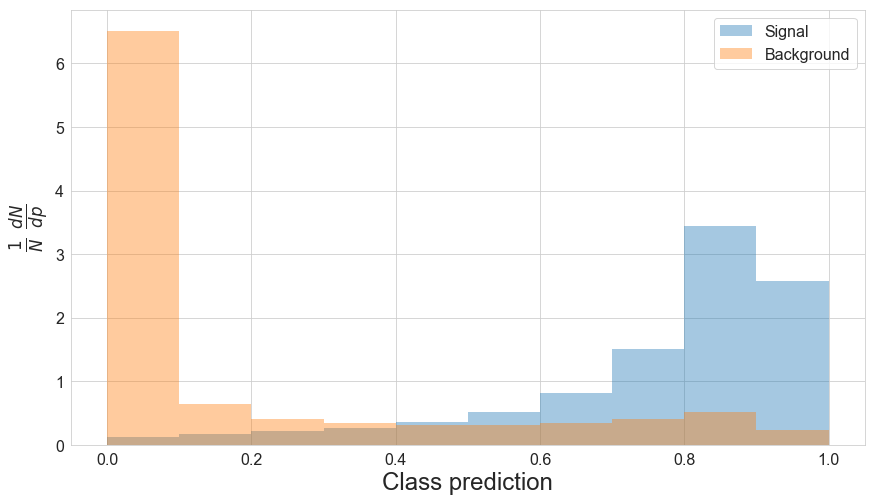

In [ ]:
plot_preds(df)

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,0.901974,1.0,9
1,0.899706,1.0,8
2,0.909807,1.0,9
3,0.864297,1.0,8
4,0.900996,1.0,9


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.0000))

In [ ]:
f_s, f_b

(tensor([0.0122, 0.0166, 0.0215, 0.0268, 0.0360, 0.0514, 0.0818, 0.1512, 0.3446,
         0.2579]),
 tensor([0.6516, 0.0634, 0.0412, 0.0337, 0.0306, 0.0304, 0.0340, 0.0405, 0.0519,
         0.0226]))

In [ ]:
t_exp = (50*f_s)+(1000*f_b)

In [ ]:
t_exp, t_exp.sum()

(tensor([652.2328,  64.2622,  42.2446,  35.0509,  32.3986,  32.9938,  38.0957,
          48.0777,  69.1145,  35.5292]), tensor(1050.))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+((n-m)*f_b))
    y[i] = -pois.log_prob(t_exp).sum()
y -= y.min()

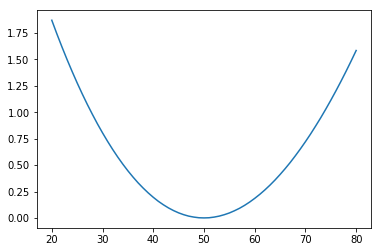

In [ ]:
plt.plot(x,y)

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [ ]:
r = InterpolatedUnivariateSpline(x, y-0.5).roots()

In [ ]:
(r[1]-r[0])/2

16.222900372647366

# Nuisances - via scan

## BM 1

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_syst_shapes(bkg, df, model=model, r_vals=[-0.2,+0.2])

Running: r=-0.2 l=3


Running: r=0.2 l=3


In [ ]:
b_shapes

OrderedDict([('-0.2_3',
              tensor([0.6301, 0.0660, 0.0429, 0.0351, 0.0328, 0.0326, 0.0358, 0.0436, 0.0566,
                      0.0247])),
             ('0.2_3',
              tensor([0.6737, 0.0608, 0.0393, 0.0318, 0.0282, 0.0289, 0.0319, 0.0373, 0.0473,
                      0.0206]))])

In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0.2_3,pred_0.2_3_bin
0,0.901974,1.0,9,0.901974,9,0.901974,9
1,0.899706,1.0,8,0.899706,8,0.899706,8
2,0.909807,1.0,9,0.909807,9,0.909807,9
3,0.864297,1.0,8,0.864297,8,0.864297,8
4,0.900996,1.0,9,0.900996,9,0.900996,9
...,...,...,...,...,...,...,...
999995,0.000004,0.0,0,0.000005,0,0.000004,0
999996,0.012382,0.0,0,0.016227,0,0.009228,0
999997,0.000120,0.0,0,0.000179,0,0.000081,0
999998,0.001073,0.0,0,0.001475,0,0.000772,0


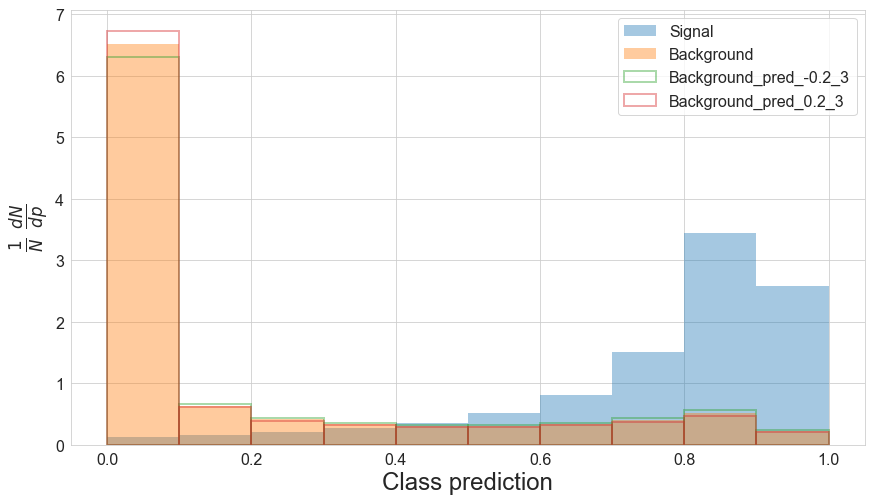

In [ ]:
plot_preds(df, pred_names=['pred']+[f'pred_{s}' for s in b_shapes])

In [ ]:
b_shapes

OrderedDict([('-0.2_3',
              tensor([0.6301, 0.0660, 0.0429, 0.0351, 0.0328, 0.0326, 0.0358, 0.0436, 0.0566,
                      0.0247])),
             ('0.2_3',
              tensor([0.6737, 0.0608, 0.0393, 0.0318, 0.0282, 0.0289, 0.0319, 0.0373, 0.0473,
                      0.0206]))])

In [ ]:
b_shapes = get_syst_shapes_as_tensor(bkg, df, model=model, r_vals=np.linspace(-0.4,0.4,9))

Running: r=-0.4 l=3


Running: r=-0.30000000000000004 l=3


Running: r=-0.2 l=3


Running: r=-0.09999999999999998 l=3


Running: r=0.0 l=3


Running: r=0.09999999999999998 l=3


Running: r=0.20000000000000007 l=3


Running: r=0.30000000000000004 l=3


Running: r=0.4 l=3


In [ ]:
b_shapes.shape

torch.Size([9, 10])

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
t_exp = (50*f_s)+(1000*b_shapes)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+((n-m)*b_shapes))
    y[i] = -pois.log_prob(t_exp).sum(1).min()
y -= y.min()

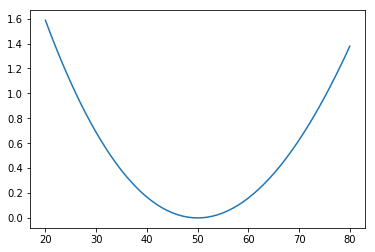

In [ ]:
plt.plot(x,y)

In [ ]:
r = InterpolatedUnivariateSpline(x, y-0.5).roots()

In [ ]:
(r[1]-r[0])/2

17.48800598003206

## BM 2

In [ ]:
b_shapes = get_syst_shapes(bkg, df, model=model, r_vals=[-0.2,+0.2],l_vals=[2.5,3.5])

Running: r=-0.2 l=2.5


Running: r=-0.2 l=3.5


Running: r=0.2 l=2.5


Running: r=0.2 l=3.5


In [ ]:
b_shapes

OrderedDict([('-0.2_2.5',
              tensor([0.6205, 0.0659, 0.0431, 0.0354, 0.0326, 0.0330, 0.0361, 0.0451, 0.0603,
                      0.0280])),
             ('-0.2_3.5',
              tensor([0.6398, 0.0657, 0.0428, 0.0350, 0.0324, 0.0319, 0.0354, 0.0420, 0.0529,
                      0.0221])),
             ('0.2_2.5',
              tensor([0.6649, 0.0611, 0.0393, 0.0319, 0.0286, 0.0291, 0.0326, 0.0384, 0.0506,
                      0.0235])),
             ('0.2_3.5',
              tensor([0.6827, 0.0603, 0.0391, 0.0315, 0.0279, 0.0285, 0.0311, 0.0361, 0.0444,
                      0.0184]))])

In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_-0.4_3,pred_-0.4_3_bin,pred_-0.30000000000000004_3,...,pred_0.4_3,pred_0.4_3_bin,pred_-0.2_2.5,pred_-0.2_2.5_bin,pred_-0.2_3.5,pred_-0.2_3.5_bin,pred_0.2_2.5,pred_0.2_2.5_bin,pred_0.2_3.5,pred_0.2_3.5_bin
0,0.901974,1.0,9,0.901974,9,0.901974,9,0.901974,9,0.901974,...,0.901974,9,0.901974,9,0.901974,9,0.901974,9,0.901974,9
1,0.899706,1.0,8,0.899706,8,0.899706,8,0.899706,8,0.899706,...,0.899706,8,0.899706,8,0.899706,8,0.899706,8,0.899706,8
2,0.909807,1.0,9,0.909807,9,0.909807,9,0.909807,9,0.909807,...,0.909807,9,0.909807,9,0.909807,9,0.909807,9,0.909807,9
3,0.864297,1.0,8,0.864297,8,0.864297,8,0.864297,8,0.864297,...,0.864297,8,0.864297,8,0.864297,8,0.864297,8,0.864297,8
4,0.900996,1.0,9,0.900996,9,0.900996,9,0.900996,9,0.900996,...,0.900996,9,0.900996,9,0.900996,9,0.900996,9,0.900996,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.000004,0.0,0,0.000005,0,0.000004,0,0.000005,0,0.000005,...,0.000003,0,0.000004,0,0.000004,0,0.000003,0,0.000003,0
999996,0.012382,0.0,0,0.016227,0,0.009228,0,0.020724,0,0.018357,...,0.007087,0,0.016085,0,0.015775,0,0.009302,0,0.008763,0
999997,0.000120,0.0,0,0.000179,0,0.000081,0,0.000266,0,0.000218,...,0.000055,0,0.000197,0,0.000165,0,0.000100,0,0.000077,0
999998,0.001073,0.0,0,0.001475,0,0.000772,0,0.001906,0,0.001681,...,0.000519,0,0.001481,0,0.001326,0,0.000751,0,0.000753,0


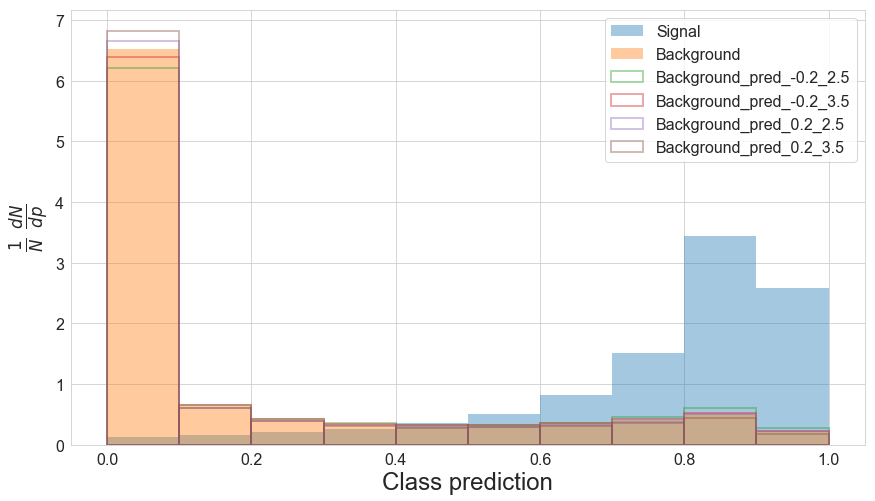

In [ ]:
plot_preds(df, pred_names=['pred']+[f'pred_{s}' for s in b_shapes])

In [ ]:
b_shapes

OrderedDict([('-0.2_2.5',
              tensor([0.6205, 0.0659, 0.0431, 0.0354, 0.0326, 0.0330, 0.0361, 0.0451, 0.0603,
                      0.0280])),
             ('-0.2_3.5',
              tensor([0.6398, 0.0657, 0.0428, 0.0350, 0.0324, 0.0319, 0.0354, 0.0420, 0.0529,
                      0.0221])),
             ('0.2_2.5',
              tensor([0.6649, 0.0611, 0.0393, 0.0319, 0.0286, 0.0291, 0.0326, 0.0384, 0.0506,
                      0.0235])),
             ('0.2_3.5',
              tensor([0.6827, 0.0603, 0.0391, 0.0315, 0.0279, 0.0285, 0.0311, 0.0361, 0.0444,
                      0.0184]))])

In [ ]:
b_shapes = get_syst_shapes_as_tensor(bkg, df, model=model, r_vals=np.linspace(-0.4,0.4,9), l_vals=np.linspace(2,4,11))

Running: r=-0.4 l=2.0


Running: r=-0.4 l=2.2


Running: r=-0.4 l=2.4


Running: r=-0.4 l=2.6


Running: r=-0.4 l=2.8


Running: r=-0.4 l=3.0


Running: r=-0.4 l=3.2


Running: r=-0.4 l=3.4000000000000004


Running: r=-0.4 l=3.6


Running: r=-0.4 l=3.8


Running: r=-0.4 l=4.0


Running: r=-0.30000000000000004 l=2.0


Running: r=-0.30000000000000004 l=2.2


Running: r=-0.30000000000000004 l=2.4


Running: r=-0.30000000000000004 l=2.6


Running: r=-0.30000000000000004 l=2.8


Running: r=-0.30000000000000004 l=3.0


Running: r=-0.30000000000000004 l=3.2


Running: r=-0.30000000000000004 l=3.4000000000000004


Running: r=-0.30000000000000004 l=3.6


Running: r=-0.30000000000000004 l=3.8


Running: r=-0.30000000000000004 l=4.0


Running: r=-0.2 l=2.0


Running: r=-0.2 l=2.2


Running: r=-0.2 l=2.4


Running: r=-0.2 l=2.6


Running: r=-0.2 l=2.8


Running: r=-0.2 l=3.0


Running: r=-0.2 l=3.2


Running: r=-0.2 l=3.4000000000000004


Running: r=-0.2 l=3.6


Running: r=-0.2 l=3.8


Running: r=-0.2 l=4.0


Running: r=-0.09999999999999998 l=2.0


Running: r=-0.09999999999999998 l=2.2


Running: r=-0.09999999999999998 l=2.4


Running: r=-0.09999999999999998 l=2.6


Running: r=-0.09999999999999998 l=2.8


Running: r=-0.09999999999999998 l=3.0


Running: r=-0.09999999999999998 l=3.2


Running: r=-0.09999999999999998 l=3.4000000000000004


Running: r=-0.09999999999999998 l=3.6


Running: r=-0.09999999999999998 l=3.8


Running: r=-0.09999999999999998 l=4.0


Running: r=0.0 l=2.0


Running: r=0.0 l=2.2


Running: r=0.0 l=2.4


Running: r=0.0 l=2.6


Running: r=0.0 l=2.8


Running: r=0.0 l=3.0


Running: r=0.0 l=3.2


Running: r=0.0 l=3.4000000000000004


Running: r=0.0 l=3.6


Running: r=0.0 l=3.8


Running: r=0.0 l=4.0


Running: r=0.09999999999999998 l=2.0


Running: r=0.09999999999999998 l=2.2


Running: r=0.09999999999999998 l=2.4


Running: r=0.09999999999999998 l=2.6


Running: r=0.09999999999999998 l=2.8


Running: r=0.09999999999999998 l=3.0


Running: r=0.09999999999999998 l=3.2


Running: r=0.09999999999999998 l=3.4000000000000004


Running: r=0.09999999999999998 l=3.6


Running: r=0.09999999999999998 l=3.8


Running: r=0.09999999999999998 l=4.0


Running: r=0.20000000000000007 l=2.0


Running: r=0.20000000000000007 l=2.2


Running: r=0.20000000000000007 l=2.4


Running: r=0.20000000000000007 l=2.6


Running: r=0.20000000000000007 l=2.8


Running: r=0.20000000000000007 l=3.0


Running: r=0.20000000000000007 l=3.2


Running: r=0.20000000000000007 l=3.4000000000000004


Running: r=0.20000000000000007 l=3.6


Running: r=0.20000000000000007 l=3.8


Running: r=0.20000000000000007 l=4.0


Running: r=0.30000000000000004 l=2.0


Running: r=0.30000000000000004 l=2.2


Running: r=0.30000000000000004 l=2.4


Running: r=0.30000000000000004 l=2.6


Running: r=0.30000000000000004 l=2.8


Running: r=0.30000000000000004 l=3.0


Running: r=0.30000000000000004 l=3.2


Running: r=0.30000000000000004 l=3.4000000000000004


Running: r=0.30000000000000004 l=3.6


Running: r=0.30000000000000004 l=3.8


Running: r=0.30000000000000004 l=4.0


Running: r=0.4 l=2.0


Running: r=0.4 l=2.2


Running: r=0.4 l=2.4


Running: r=0.4 l=2.6


Running: r=0.4 l=2.8


Running: r=0.4 l=3.0


Running: r=0.4 l=3.2


Running: r=0.4 l=3.4000000000000004


Running: r=0.4 l=3.6


Running: r=0.4 l=3.8


Running: r=0.4 l=4.0


In [ ]:
b_shapes.shape

torch.Size([99, 10])

In [ ]:
nll = likelihood_from_scan(f_s, b_shapes)

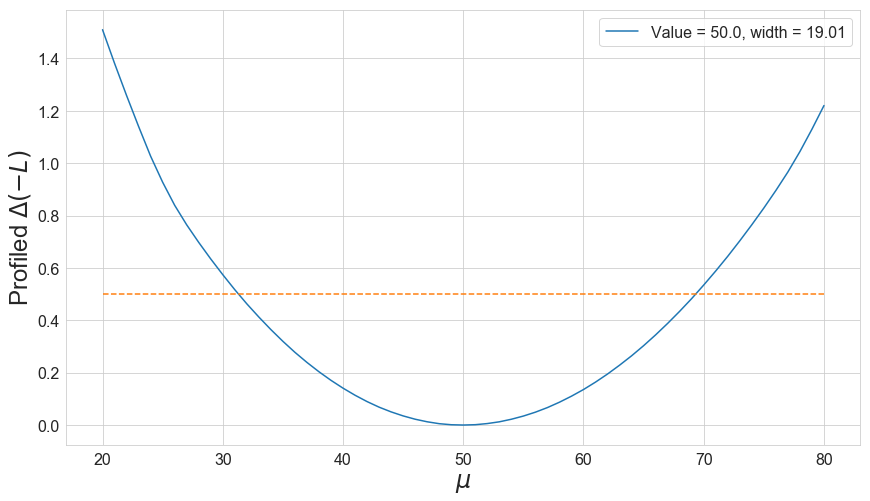

In [ ]:
plot_likelihood(nll)